# Parte 2 - Modelo de Cantidad Vendida

En este Notebook se desarrollará el Análisis Exploratorio para la creación de un modelo que permita predecir la cantidad vendida, *sold_quantity*, de un producto basado en sus características.

## 1. Carga de Datos

Se realizará la carga de datos como se describió en la Parte 1. Se tiene información de hasta 10.000 productos por cada categoría (31 en total) a corte del 24 de diciembre de 2020. En total se registra información de 271.082 productos entre las 31 categorías.

En este cargue se incluye como pre-procesamiento la construcción de las variables utilizadas para el Análisis Exploratorio de productos con descuento.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import  matplotlib.pyplot as plt
import matplotlib.ticker as mtick
sns.set(rc={'figure.figsize':(10, 5)})

In [2]:
data_folder = '../data'
data_by_category = [pd.read_csv(os.path.join(data_folder, file), sep = ";") for file in os.listdir('../data') if file.find('.csv') != -1]
complete_df = pd.concat(data_by_category, axis = 0, ignore_index=True)
complete_df['has_discount'] = ~complete_df.original_price.isnull()

In [3]:
complete_df.columns

Index(['id', 'title', 'price', 'available_quantity', 'sold_quantity',
       'buying_mode', 'listing_type_id', 'condition', 'accepts_mercadopago',
       'original_price', 'category_id', 'seller_level_id',
       'seller_powerseller', 'positive_rating', 'negative_rating',
       'neutral_rating', 'free_shipping', 'store_pickup', 'number_of_tags',
       'is_official_store', 'month_update', 'year_update', 'year_created',
       'month_created', 'total_questions', 'category_name', 'has_discount'],
      dtype='object')

In [4]:
# Cálculo del descuento aplicado al producto
complete_df.loc[complete_df.original_price.isnull(), 'vlr_descuento'] = 0
complete_df.loc[~complete_df.original_price.isnull(), 'vlr_descuento'] = round(1 - complete_df['price']/complete_df['original_price'], 2)

In [5]:
# Construcción de un indicador de antigüedad en meses. 
actual_year = 2020
actual_month = 12
complete_df['product_age'] = 12*(actual_year - complete_df.year_created) + (actual_month - complete_df.month_created) + 1

In [6]:
# Modificadores de Reputación
complete_df.loc[complete_df.seller_powerseller.isna(), 'seller_powerseller'] = 'NotPowerSeller'

complete_df.loc[complete_df.seller_level_id.isnull(), 'seller_level_id'] = 'NoColor'
complete_df.loc[complete_df.seller_level_id.isin(['5_green', '4_light_green']), 'GroupedReputation'] = 'Green Seller'
complete_df.loc[complete_df.seller_level_id.isin(['2_orange', '1_red']), 'GroupedReputation'] = 'Orange Seller'
complete_df.loc[complete_df.seller_level_id == '3_yellow', 'GroupedReputation'] = 'Yellow Seller'
complete_df.loc[complete_df.seller_level_id == 'NoColor', 'GroupedReputation'] = 'No Color'

In [7]:
# Se crea una característica indicando si la foto fue actualizada
complete_df.loc[(complete_df.year_update == complete_df.year_created) & (complete_df.month_update == complete_df.month_created), 'updated_picture'] = False
complete_df.loc[(complete_df.year_update != complete_df.year_created) | (complete_df.month_update != complete_df.month_created), 'updated_picture'] = True

## 2. Análisis Exploratorio

La variable de interés es denominada *sold_quantity*, y corresponde a una variable categórica que define rangos para una variable latente de cantidad vendida. Dependiendo del valor real de cantidad que se ha vendido de un producto (Dato Real), la variable se codifica como aparece en Referencia, de acuerdo con la siguiente tabla:

| Dato Real | Referencia   |
|------|------|
|1|1|
|2|2|
|3|3|
|4|4|
|5|5|
|RANGO_6_25|5|
|RANGO_26_50|25|
|RANGO_51_100|50|
|RANGO_101_150|100|
|RANGO_151_200|150|
|RANGO_201_250|200|
|RANGO_251_500|250|
|RANGO_501_5000|500|
|RANGO_5001_50000|5000|
|RANGO_50001_500000|50000|
[Fuente.](https://developers.mercadolibre.com.co/es_ar/items-y-busquedas)

A continuación se observa la distribución de las categorías de cantidades vendidas (*sold_quantity*). Se resalta el hecho de que es un conjunto de datos que NO está balanceado en esta categoría. Hay baja representación ventas de 5001-50.000 y no hay representación de ventas superiores a 50.001 unidades. De esta forma, el modelo que se obtenga como resultado deberá ser evaluado teniendo en cuenta lo anterior, y no será capaz de predecir ventas de productos superiores a 50.000 unidades. 


In [19]:
complete_df.sold_quantity.value_counts()/len(complete_df)*100

5       29.308475
0       19.128898
1       10.335987
25      10.190643
50       7.595488
2        5.937687
3        4.243734
4        3.547266
100      3.211574
250      2.173512
150      1.695797
500      1.519466
200      1.079378
5000     0.032094
Name: sold_quantity, dtype: float64

### 2.1 Antigüedad y Preguntas

Debido a que se va a analizar la variable de total de unidades vendidas (sold quantity) y esta es una variable de stock, se espera que entre más antiguo sea un producto en el Marketplace, mayor será la cantidad vendida de este. El siguiente gráfico muestra la distribución de la antigüedad condicional al total de unidades vendidas. En él se puede apreciar que los productos con menos de 5 unidades vendidas tienen, en su mayoría, menos de 2 años en el Marketplace. En contraste, los productos con una mayor cantidad de unidades vendidas tienen significativamente más tiempo de ser publicados.

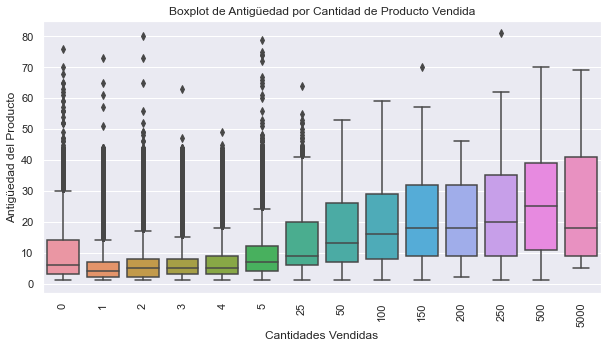

In [9]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="product_age", data=complete_df)
plt.title('Boxplot de Antigüedad por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Antigüedad del Producto')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

Adicionalmente, se analiza la relación entre la cantidad de preguntas realizadas a los productos y su cantidad vendida. Se observa que la cantidad de preguntas en productos que tienen ventas de más de 200 unidades es significativamente mayor comparado con aquellos productos con menores ventas.

(0.0, 4000.0)

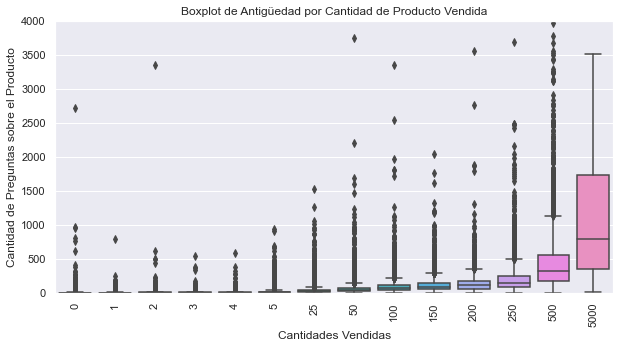

In [10]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="total_questions", data=complete_df[complete_df.total_questions > 0])
plt.title('Boxplot de Antigüedad por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Cantidad de Preguntas sobre el Producto')
_ = plt.setp(ax.get_xticklabels(), rotation=90)
plt.ylim((0, 4000))

Este resultado es relvante, puesto que el 92% de los productos del Marketplace tienen preguntas [naranja].

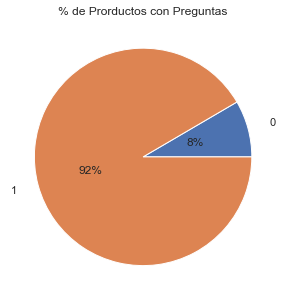

In [12]:
complete_df['has_questions'] = 1*(~complete_df.total_questions.isnull())

complete_df.has_questions.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('% de Prorductos con Preguntas')
plt.show()

### 2.2. Cantidad Disponible

En principio, la cantidad vendida de un producto podría identificarse utilizando información de la cantidad disponible para la venta y el total de unidades disponibles en publicación. Sin embargo, sólo se cuenta con información de las cantidades disponibles. Esta variable se encuentra discretizada de acuerdo a la siguiente tabla:

| Dato Real | Referencia   |
|------|------|
|RANGO_0_50|1|
|RANGO_51_100|50|
|RANGO_101_150|100|
|RANGO_151_200|150|
|RANGO_201_250|200|
|RANGO_251_500|250|
|RANGO_501_5000|500|
|RANGO_5001_50000|5000|
|RANGO_50001_99999|50000|
[Fuente.](https://developers.mercadolibre.com.co/es_ar/items-y-busquedas)


A continuación realizamos un gráfico de barras para determinar si existen concentraciones diferenciadas por categoría de cantidad vendida. 

<Figure size 720x720 with 0 Axes>

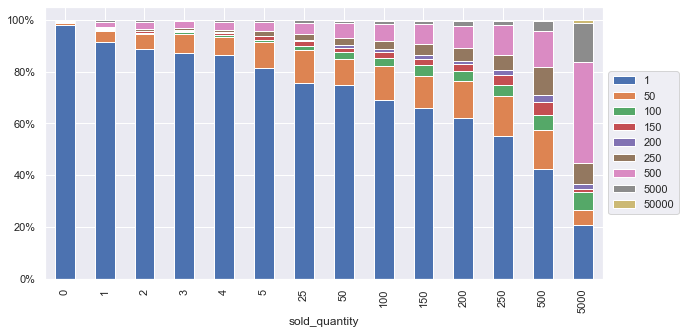

In [13]:
plt.figure(figsize = (10, 10))
complete_df.groupby(['sold_quantity','available_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Se puede observar que la categoría de cantidad disponible 1 (de 0 a 50 unidades disponibles) presenta la mayor concentración para cantidades vendidas de 501-5000 unidades. Sin embargo, para productos con entre 5.000 y 50.000 unidades vendidas, las cantidades disponibles se concentran, en su mayoría, en 500 (501-5.000 unidades disponibles).

Este resultado indica que la variable de cantidades disponibles no es informativa para productos con unidades vendidas de hasta rango 500-5.000.



### 2.3 Niveles de Descuento
En el siguiente gráfico se investiga brevemente la relación entre el nivel de descuento de un producto y su cantidad de ventas. Se esperaría que la relación obedeciera a alguna de las siguientes dos hipótesis:

- Debido a las bajas ventas de un producto, el vendedor aplica un descuento mayor al que había anteriormente para incentivar la venta.
- Los productos con más ventas seguramente tienen descuentos mayores comparados con los que tienen menos ventas. 

El gráfico muestra que ninguna de las dos hipótesis domina completamente, y no existe una relación clara entre el nivel de descuentos y la cantidad vendida. Adicionalmente, la cantidad de productos que presentan descuentos es apenas del 3%.

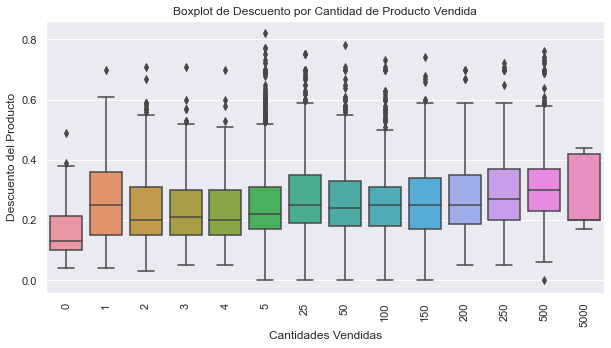

In [14]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="vlr_descuento", data=complete_df[complete_df.has_discount])
plt.title('Boxplot de Descuento por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Descuento del Producto')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

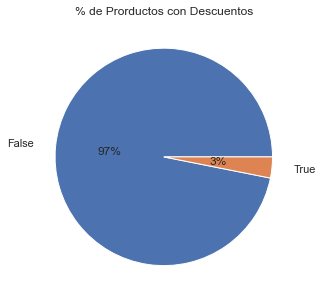

In [12]:
complete_df.has_discount.value_counts().sort_index().plot.pie(ylabel = '',  autopct='%1.0f%%', pctdistance=0.5, labeldistance=1.2)
plt.title('% de Prorductos con Descuentos')
plt.show()

### 2.4 Relación Cantidades Vendidas con Categorías de Producto

En esta sección se comienza a analizar la importancia en las categorías de los productos y sus unidades vendidas. El siguiente gráfico relaciona la proporción de categoría de unidades vendidas por cada categoría de productos. Se puede apreciar que las categorías "Carros, Motos y Otros", "Inmuebles" y "Servicios" tienen 0 unidades vendidas en el 100% de sus productos. Este es un hallazgo bastante interesante y va acorde con la realidad, pues los productos listados en la API deben tener unidades disponibles. Así, cuando un vendedor consigue vender su única unidad de inmueble o vehículo, este se da de baja en el Marketplace.

A partir de aquí se decide excluir de los análisis posteriores estos tipos de productos.

<Figure size 720x720 with 0 Axes>

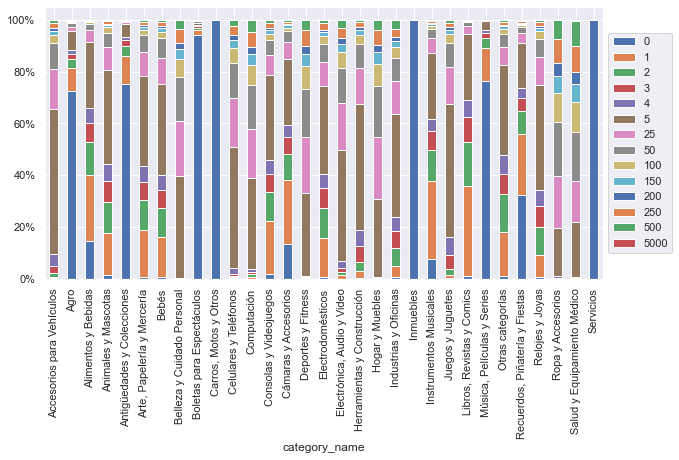

In [15]:
# Vamos a quitar esas tres categorías porque no spueden dañar los otros análisis. Ya lo vamos a tener en cuenta. 
plt.figure(figsize = (10, 10))
complete_df.groupby(['category_name','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Adicionalmente, se puede observar que la categoría de cantidad vendida con mayor representación dentro de las categorías de producto es ventas de 5 - 25 unidades. 

In [14]:
df_sin_tres_categorias = complete_df[~complete_df.category_name.isin(['Carros, Motos y Otros', 'Inmuebles', 'Servicios'])]

### 2.5 Reputación del Vendedor

Se analiza si existe alguna relación entre el estatus de Mercadolíder y las cantidades vendidas de un producto. Se esperaría que los vendedores con mayor categoría de Mercadolíder tengan productos con mayor cantidad de ventas acumuladas. Sin embargo, el siguiente gráfico muestra que esto no es necesariamente cierto. Se observa que la concentracíon de diferentes cantidades vendidas es bastante similar a través de las categorías de Mercadolíder.

<Figure size 720x720 with 0 Axes>

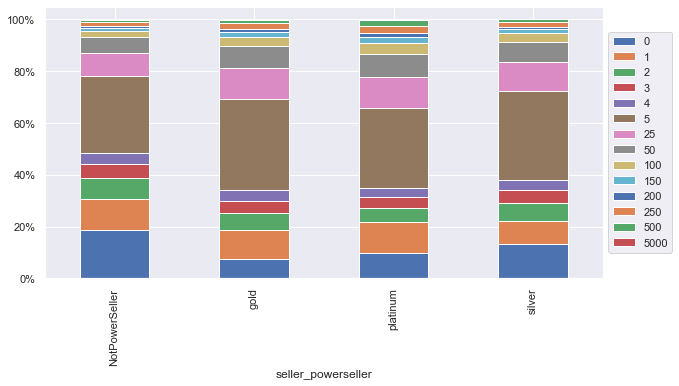

In [18]:

plt.figure(figsize = (10, 10))
df_sin_tres_categorias.groupby(['seller_powerseller','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

### 2.6 Características de la Publicación

En esta sección se analiza si existen características de las publicaciones que predominen en algunas categorías de venta. El siguiente gráfico presenta una la distribución del *listing_type_id* de los productos. Esta característica está asociada a los cobros por comisión que se realizan sobre la venta de un producto [(Fuente).](https://developers.mercadolibre.com.ar/es_ar/comision-por-publicar) Se puede observar que las publicaciones que vienen bajo comisión 0 (*free*) no tienen unidades vendidas.  Esta es una variable que ayuda a discriminar en gran parte los productos que no han vendido unidades. 

Sin embargo, en el Marketplace existen más de tres tipos de listings, y es posible que se hayan filtrado al excluir del análisis las tres categorías de productos cuyas ventas estaban completamente en 0.



<Figure size 720x720 with 0 Axes>

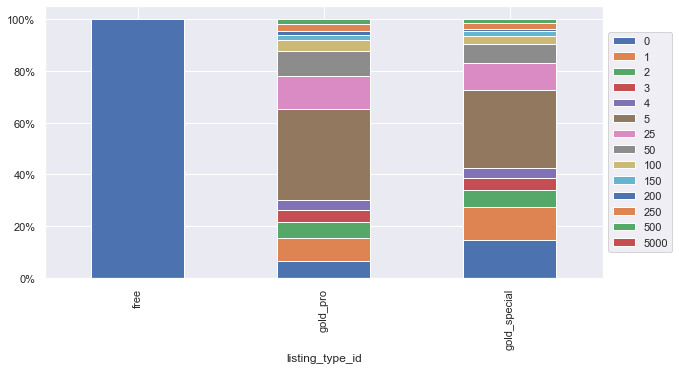

In [22]:
plt.figure(figsize = (10, 10))
df_sin_tres_categorias.groupby(['listing_type_id','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

# Este gráfico tiene más barras azules si se dejan las tres categorías que sabíamos.

Al tener en cuenta las categorías de producto excluídas del análisis se obtiene que únicamente los *listings* que corresponden a *gold_pro* y *gold_special* tienen cantidades vendidas diferentes a cero. De esta forma, se encontró una variable que permite identificar adecudamente a todos los productos que no tienen ventas. Así, un producto cuya comisión sea distinta a *gold_pro* y *gold_special* tendrá unidades vendidas de 0 (lo contrario no es cierto). 

De esta forma no es necesario excluir ni marcar de manera distintiva las categorías "Carros, Motos y Otros", "Inmuebles" y "Servicios".

<Figure size 720x720 with 0 Axes>

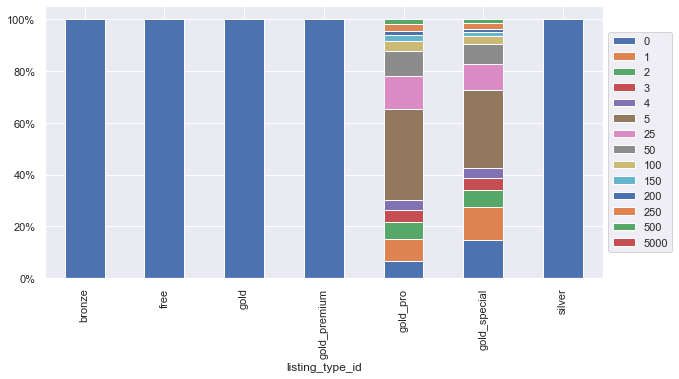

In [23]:
plt.figure(figsize = (10, 10))
complete_df.groupby(['listing_type_id','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Finalmente se analiza si los productos cuya foto de miniatura fue actualizada dentro de su vigencia de publicación tienen concentraciones diferentes de unidades vendidas. 

El siguiente gráfico muestra que aquellos productos cuya foto de miniatura fue actualizada presentan concentraciones en categorías de menor venta. Sin embargo, esta diferencia no resulta significativa.

<Figure size 720x720 with 0 Axes>

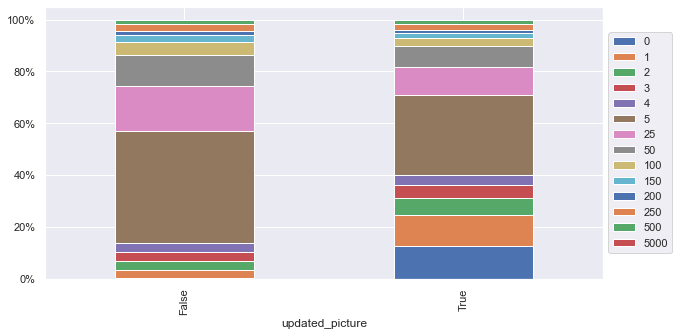

In [21]:
plt.figure(figsize = (10, 10))
df_sin_tres_categorias.groupby(['updated_picture','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

### 2.6 Características Propias del producto

En este apartado se analizan propiedades inherentes al cada producto. Se comienza analizando la relación entre la condición del producto y las cantidades vendidas. 

El siguiente gráfico muestra que la cantidad vendida de productos usados se concentra, casi en su totalidad, en 0.

<Figure size 720x720 with 0 Axes>

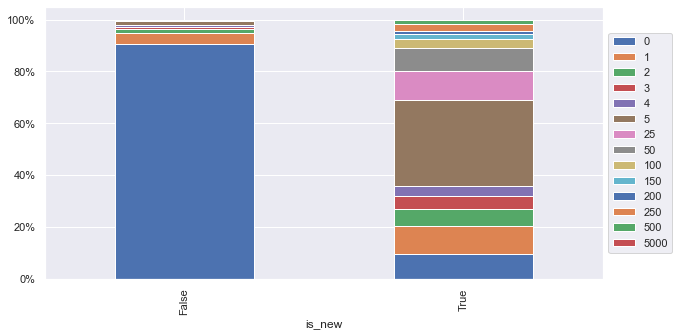

In [17]:
plt.figure(figsize = (10, 10))
complete_df['is_new'] = complete_df.condition=='new'

complete_df.groupby(['is_new','sold_quantity']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True).legend(loc='center left',bbox_to_anchor=(1.0, 0.5));

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

Finalmente, se muestra que no es posible utilizar el precio del Marketplace como una característica dentro de los modelos que se vayan a crear. El precio de los productos presenta muchísima dispersión, inclusive cuando se controla por las categorías de "Inmuebles" y "Carros, Motos y Otros". Hay una gran cantidad de productos con precios muy bajos y una gran cantidad de productos con precios muy altos. Este fenómeno no sólo se presenta a través de cantidades vendidas, sino tambíen persiste cuando se analiza por categoría de producto. 

In [26]:
df_sin_tres_categorias.price.describe()

count    2.483820e+05
mean     2.154542e+05
std      2.074786e+06
min      2.000000e+00
25%      2.500000e+04
50%      5.990000e+04
75%      1.403498e+05
max      6.500000e+08
Name: price, dtype: float64

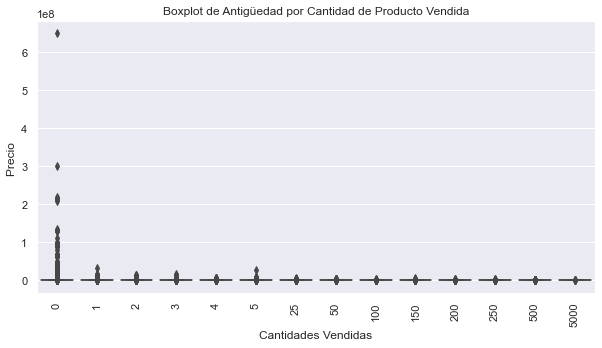

In [20]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="price", data=df_sin_tres_categorias)
plt.title('Boxplot de Antigüedad por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Precio ')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

# Sería chévere utilizarla pero nos quedamos con nulos. Y ni puta idea de cómo sacar lasmedianas de cada categoría. Al hacerlo de dentro de la categoría igual sigue siendo horrible Entonces paila

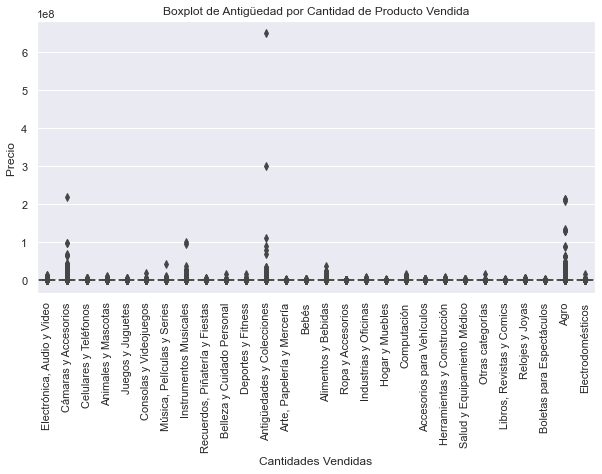

In [21]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="category_name", y="price", data=df_sin_tres_categorias)
plt.title('Boxplot de Antigüedad por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Precio ')
_ = plt.setp(ax.get_xticklabels(), rotation=90)


Sin embargo, el precio original de los productos sí tiene una relación con las cantidades vendidas de cada producto. A pesar de esto, no es una característica de mucha utilidad, puesto que apenas el 3% de los productos tiene descuento.

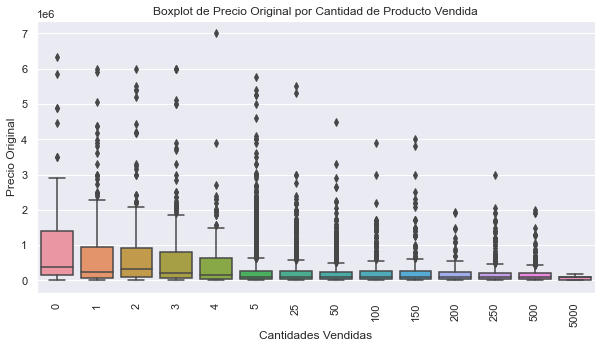

In [22]:
plt.figure(figsize = (10, 5))
ax = sns.boxplot(x="sold_quantity", y="original_price", data=df_sin_tres_categorias)
plt.title('Boxplot de Precio Original por Cantidad de Producto Vendida')
plt.xlabel('Cantidades Vendidas')
plt.ylabel('Precio Original')
_ = plt.setp(ax.get_xticklabels(), rotation=90)

## 3. Discusión de Resultados del Análisis Exploratorio

En esta sección se discutirán los resultados del Análisis Exploratorio para el modelo de Cantidades Vendidas (*sold_quantity*). Se considera que con el conocimiento obtenido hasta el momento es posible identificar con una precisión adecuada cuándo un producto no ha vendido unidades (*sold_quantity = 0*). Sin embargo, poder discriminar entre el resto de categorías parece ser una tarea bastante complicada, por lo menos con la información recolectada hasta el momento. 

Por lo anterior se propone probar con dos modelos. 

- **Modelo 1:** Predicción de *sold_quantity* directamente
- **Modelo 2:** Predicción de cinco categorías: 0 unidades vendidas, [1 - 4] unidades vendidas, [5 - 25], (25, 50], 50+ unidades vendidas.
    - Este último podría utilizarse para predecir grupos sobre los cuáles utilizar un modelo específico. 
    
Y se comparará directamente su desempeño con una predicción basada en la moda por años de antigüedad, corregida por:
- **Tipo de comisión:** Diferente a *gold_pro* o *gold_special* > Predicción 0
- **Condición del Producto:** Usado -> Predicción 0

# 3. Train Test Split
Puedo hacer un pipeline de modelo:
Si tiene el golden diferente, entonces ya de una que prediga el 0. 
Y luego si use un modelo

In [52]:
# Vamos a agrupar las categorías de 1-5, porque tienen un comportamiento similar en todos los casos.
# Además que no pareciera haber información para discriminarlas. 
complete_df['golden_categories'] = 1*(complete_df.listing_type_id.isin(['gold_pro', 'gold_special']))
complete_df['is_new'] = 1*(complete_df.condition=='new')
complete_df.loc[complete_df.sold_quantity < 5, 'sold_group'] = 3
complete_df.loc[complete_df.sold_quantity == 5, 'sold_group'] = 5
complete_df.loc[complete_df.sold_quantity > 5, 'sold_group'] = 10
complete_df.loc[complete_df.sold_quantity == 0, 'sold_group'] = 0

features = ['golden_categories', 'is_new','total_questions', 'product_age', 'has_questions', 
            
            'has_discount' , 'updated_picture']

target = ['sold_quantity']
target_2 = ['sold_group']


X = complete_df[features]
y = complete_df[target_2].astype('int64')

X.product_age.fillna(X.product_age.median(), inplace=True)
X.total_questions.fillna(0, inplace=True)

c:\users\juan\appdata\local\programs\python\python38-32\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [53]:
X[X.isnull().any(axis=1)]

,golden_categories,is_new,total_questions,product_age,has_questions,has_discount,updated_picture


In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# 4. Modelo

In [55]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
clf = RandomForestClassifier(n_estimators=2000)
clf = clf.fit(X_train, y_train)

<ipython-input-55-09aff3e97a45>:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X_train, y_train)


MemoryError: Unable to allocate 1.39 MiB for an array with shape (181624,) and data type float64

In [ ]:
prediction = clf.predict(X_test)

In [ ]:
f1_score(prediction, y_test, average = 'macro')

In [ ]:

cf = plot_confusion_matrix(y_test, prediction, np.unique(y), normalize=True)

In [51]:
# Vamos a agrupar las categorías de 1-5, porque tienen un comportamiento similar en todos los casos.
# Además que no pareciera haber información para discriminarlas. 
complete_df['golden_categories'] = 1*(complete_df.listing_type_id.isin(['gold_pro', 'gold_special']))
complete_df['is_new'] = 1*(complete_df.condition=='new')
complete_df.loc[complete_df.sold_quantity < 5, 'sold_group'] = 3
complete_df.loc[complete_df.sold_quantity == 5, 'sold_group'] = 5
complete_df.loc[complete_df.sold_quantity > 5, 'sold_group'] = 10
complete_df.loc[complete_df.sold_quantity == 0, 'sold_group'] = 0

features = ['golden_categories', 'is_new','total_questions', 'product_age', 'has_questions', 
            
            'has_discount' , 'updated_picture']

target = ['sold_quantity']
target_2 = ['sold_group']


X = complete_df[complete_df.sold_group == 10][features]
y = complete_df[complete_df.sold_group == 10][target].astype('int64')

X.product_age.fillna(X.product_age.median(), inplace=True)
X.total_questions.fillna(0, inplace=True)